<a href="https://colab.research.google.com/github/reggiebain/data-projects/blob/main/Rotten_Tomatoes_Deep_Learning_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Certified Fresh vs. Fresh vs. Rotten
- In this notebook, we use deep learning NLP techniques to predict the ordinal ratings of movies on Rotten Tomatoes.
- Our task will be to predict the "review type" meaning Fresh, or Rotten. Here, we will focus on critic reviews. NOTE: Critic review does not necessarily dictate the tomatometers status overall review.
- In a separate project, we focused on data from audience reviews and found a highly successful classifier. 
- We can train a pre-trained NLP classifier on the sentiment of critic reviews using the "review_type" and "review_content" features

### TODO:
- [ ] Import NLP Libraries
- [ ] EDA to Explore Critic Review Data Set
- [ ] Encode data and prepare for ML
- [ ] Train BERT on new data
- [ ] Evaluate with learning curves, etc.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install matplotlib --upgrade;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# Import dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import statistics as stats

import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses

colormap = mpl.colormaps['tab10']
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#from bert_sklearn import BertClassifier
#from bert_sklearn import BertRegressor
#from bert_sklearn import BertTokenClassifier
#from bert_sklearn import load_model

In [3]:
# Read in critic reviews of movies
critics = pd.read_csv('/content/drive/MyDrive/Data-Science/rotten_tomatoes_critic_reviews_50k.csv')
movies = pd.read_csv('/content/drive/MyDrive/Data-Science/rotten_tomatoes_movies.csv')
critics.head(1)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...


In [4]:
# Merge data sets to get movie title and tomatometer_status (which is our target).
merged = pd.merge(critics, movies, on='rotten_tomatoes_link')
data = merged[['rotten_tomatoes_link','critic_name','movie_title','review_content','review_type', 'tomatometer_status']]

# Drop rows where there is no target
data_nona = data.dropna(subset=['review_type', 'review_content'])
data_nona.head(1)

,rotten_tomatoes_link,critic_name,movie_title,review_content,review_type,tomatometer_status
0,m/0814255,Andrew L. Urban,Percy Jackson & the Olympians: The Lightning T...,A fantasy adventure that fuses Greek mythology...,Fresh,Rotten


Text(0.5, 1.0, 'Tomatometer Status')

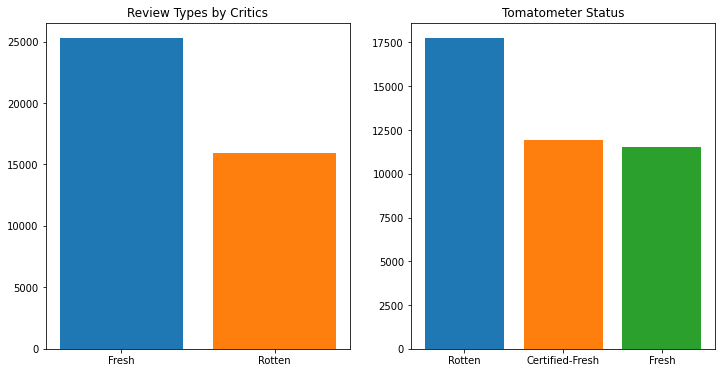

In [8]:
# Drop entries with missing data
fig, axs = plt.subplots(1,2, figsize=(12,6))
fig1 = axs[0].bar(x=data_nona.review_type.unique(),height=data_nona.review_type.value_counts(),color=colormap.colors)
axs[0].set_title('Review Types by Critics')
#axs[0].bar_label(fig1, padding = 3)
fig2 = axs[1].bar(x=data_nona.dropna(subset=['tomatometer_status']).tomatometer_status.unique(),height=(data_nona.dropna(subset=['tomatometer_status'])).tomatometer_status.value_counts(),color=colormap.colors)
axs[1].set_title('Tomatometer Status')
#axs[1].bar_label(fig2, padding=3)

#### Isolate training data and Preprocess
- [X] Isolate relevant training/validation/testing data and drop na's
- [X] Define preprocessing function
- [X] Split into train/val/test tests with SKLearn
- [ ] Create TF/Keras dataset. 
- [X] Define RNN with LSTMs etc.
- [X] Evaluate Accuracy

In [9]:
data_nona.head(1)

,rotten_tomatoes_link,critic_name,movie_title,review_content,review_type,tomatometer_status
0,m/0814255,Andrew L. Urban,Percy Jackson & the Olympians: The Lightning T...,A fantasy adventure that fuses Greek mythology...,Fresh,Rotten


In [11]:
# Isolate and Preprocess Data
import re

data = data_nona[['review_content', 'review_type']]
proc_data = pd.DataFrame()
def preprocess(input):
  input = re.sub('<br\\s*/?,\(\)>', ' ',input)
  input = re.sub("[^a-zA-Z']", ' ', input)
  input = input.lower()
  return input

# Preprocess review content to clean up review text
proc_data['review_content'] = data['review_content'].apply(lambda x: preprocess(x))

# Assign 0/1 (or ordinal encoding) to review labels
proc_data['review_type'] = data.review_type.apply(lambda x: 0 if x=='Rotten' else 1)

1

In [12]:
from sklearn.model_selection import train_test_split 
X_train_full, X_test, y_train_full, y_test = train_test_split(proc_data[['review_content']], proc_data[['review_type']], test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1)

In [13]:
# For tokenizing, create lists of training and testing data and labels
import numpy as np 
X_train_list = X_train['review_content'].tolist()
X_val_list = X_val['review_content'].tolist()
X_test_list = X_test['review_content'].tolist()


y_train_list = np.array(y_train['review_type'].tolist())
y_val_list = np.array(y_val['review_type'].tolist())
y_test_list = np.array(y_test['review_type'].tolist())

In [14]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers

vocab_size = 10000
max_len = 200
num_oov_buckets = 1000
embed_size = 128

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train_list)
word_index = tokenizer.word_index

In [16]:
max_id = len(word_index)
max_id

34251

In [17]:
# Create numeric sequences from the tokenizer. Then create padded sequences to make the same length
sequences = tokenizer.texts_to_sequences(X_train_list)
padded = pad_sequences(sequences, maxlen=max_len)
val_sequences = tokenizer.texts_to_sequences(X_val_list)
val_padded = pad_sequences(val_sequences, maxlen=max_len)
test_sequences = tokenizer.texts_to_sequences(X_test_list)
test_padded = pad_sequences(test_sequences, maxlen=max_len)

In [29]:
print(padded)

[[   0    0    0 ...  702    1  335]
 [   0    0    0 ... 5653 1457  487]
 [   0    0    0 ...    3  256 1458]
 ...
 [   0    0    0 ...   11    2 3555]
 [   0    0    0 ...  318    4  707]
 [   0    0    0 ...    7 2857  139]]


In [76]:
# Defining a simple model
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, input_length=max_len),
    keras.layers.LSTM(embed_size, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.LSTM(embed_size),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation='sigmoid'))
])

#model = tf.keras.Sequential([
#    tf.keras.layers.Embedding(vocab_size, embed_size, input_length=max_len),
#    tf.keras.layers.GlobalAveragePooling1D(),
#    tf.keras.layers.Dense(6, activation='relu'),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

In [77]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 6)                 774       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 1,280,781
Trainable params: 1,280,781
Non-trainable params: 0
_________________________________________________________________


In [78]:
num_epochs = 20
history = model.fit(padded, y_train_list, epochs = num_epochs, validation_data = (val_padded, y_val_list))

Epoch 1/20
1043/1043 [==============================] - 18s 16ms/step - loss: 0.6430 - accuracy: 0.6243 - val_loss: 0.5738 - val_accuracy: 0.6936
Epoch 2/20
1043/1043 [==============================] - 17s 16ms/step - loss: 0.5139 - accuracy: 0.7516 - val_loss: 0.4900 - val_accuracy: 0.7678
Epoch 3/20
1043/1043 [==============================] - 17s 16ms/step - loss: 0.4279 - accuracy: 0.8135 - val_loss: 0.4765 - val_accuracy: 0.7743
Epoch 4/20
1043/1043 [==============================] - 17s 16ms/step - loss: 0.3840 - accuracy: 0.8377 - val_loss: 0.4722 - val_accuracy: 0.7780
Epoch 5/20
1043/1043 [==============================] - 17s 16ms/step - loss: 0.3510 - accuracy: 0.8537 - val_loss: 0.4815 - val_accuracy: 0.7799
Epoch 6/20
1043/1043 [==============================] - 18s 17ms/step - loss: 0.3311 - accuracy: 0.8627 - val_loss: 0.4994 - val_accuracy: 0.7810
Epoch 7/20
1043/1043 [==============================] - 16s 16ms/step - loss: 0.3175 - accuracy: 0.8689 - val_loss: 0.5291 -

In [64]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [34]:
# Alternate model using Bi-Directional 1 layer LSTM
model2 = keras.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, input_length=max_len),
    keras.layers.Bidirectional(layers.LSTM(int(embed_size/2))),
    #keras.layers.LSTM(15, dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 128)          1408000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,506,945
Trainable params: 1,506,945
Non-trainable params: 0
_________________________________________________________________


In [35]:
#Implement model checkpoins to get NN performance at its best
from keras.callbacks import ModelCheckpoint
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)
num_epochs=10
history = model2.fit(padded, y_train_list, epochs = num_epochs, validation_data = (val_padded, y_val_list), callbacks=[checkpoint2])

Epoch 1/10
1043/1043 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.7446
Epoch 1: val_accuracy improved from -inf to 0.80124, saving model to best_model2.hdf5
1043/1043 [==============================] - 279s 264ms/step - loss: 0.5140 - accuracy: 0.7446 - val_loss: 0.4239 - val_accuracy: 0.8012
Epoch 2/10
1043/1043 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.8426
Epoch 2: val_accuracy improved from 0.80124 to 0.80205, saving model to best_model2.hdf5
1043/1043 [==============================] - 272s 261ms/step - loss: 0.3559 - accuracy: 0.8426 - val_loss: 0.4183 - val_accuracy: 0.8020
Epoch 3/10
1043/1043 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.8860
Epoch 3: val_accuracy did not improve from 0.80205
1043/1043 [==============================] - 289s 277ms/step - loss: 0.2647 - accuracy: 0.8860 - val_loss: 0.4550 - val_accuracy: 0.7958
Epoch 4/10
1043/1043 [==============================] - ETA: 0s - los

In [39]:
!mkdir -p saved_model
model2.save('saved_model/my_model_lstm2') 

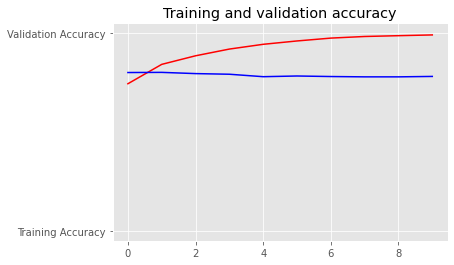

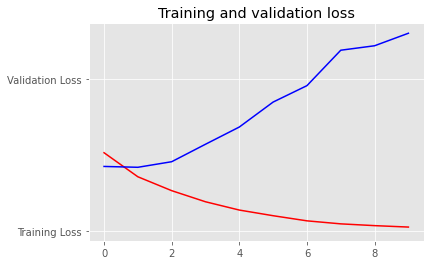

<Figure size 432x288 with 0 Axes>

In [65]:
plot_learning(history)

In [60]:
best_model = keras.models.load_model("best_model2.hdf5")
test_loss, test_acc = best_model.evaluate(test_padded, y_test_list, verbose=2)
print('Model accuracy: ',test_acc)

129/129 - 8s - loss: 0.4370 - accuracy: 0.7883 - 8s/epoch - 66ms/step
Model accuracy:  0.7883495092391968


In [61]:
# Create predictions from the best model on the test data
predictions = best_model.predict(test_padded)

129/129 [==============================] - 9s 67ms/step


In [69]:
# Create y_pred, which is a list of 0's and 1's based on the probs we got from the sigmoid later
y_pred = np.array([1 if p > 0.5 else 0 for p in predictions])

array([1, 0, 1, ..., 0, 0, 1])

In [70]:
# Plot results via confusion matrix
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test_list, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1594
           1       0.83      0.83      0.83      2526

    accuracy                           0.79      4120
   macro avg       0.78      0.78      0.78      4120
weighted avg       0.79      0.79      0.79      4120



In [ ]:
### TODO: Predict Sentiment of Individual Movie Review

In [71]:

# Use model to predict sentiment of a new movie review
def predict_movie_status(prediction):
    
    pos = (prediction == 1).sum()/len(prediction)
    
    prediction = 'Fresh' if pos >= 0.50 else 'Rotten'
    
    print(f'Positive review:{pos:.2f}%')
    print(f'Movie status: {prediction}')

In [84]:
df = data_nona.loc[data_nona['movie_title'] == 'Titanic']
df.head()

,rotten_tomatoes_link,critic_name,movie_title,review_content,review_type,tomatometer_status
33514,m/1056130-titanic,Christopher Null,Titanic,fair enough,Fresh,Fresh
33515,m/1056130-titanic,John J. Puccio,Titanic,"...a good motion picture despite its shallow, ...",Fresh,Fresh
33516,m/1056130-titanic,Ken Hanke,Titanic,Manages to tell its tale in a compact 98 minut...,Fresh,Fresh
33518,m/1056130-titanic,James Sanford,Titanic,"Exciting, well-acted version of the infamous v...",Fresh,Fresh
33519,m/1056130-titanic,Ryan Cracknell,Titanic,Not as big as James Cameron's computer-generat...,Fresh,Fresh


In [85]:
#data_nona.movie_title.unique().tolist()

In [ ]:
# Get a prediction
the_sequence = tokenizer.texts_to_sequences(X_train_list)
padded = pad_sequences(sequences, maxlen=max_len)
y_predicted_bol = best_model.predict(vectorizer.transform(df_bol['review_content']).toarray())
predict_movie_status(y_predicted_bol)